# Multi-agent supervisor

The [previous example](../multi-agent-collaboration) routed messages automatically based on the output of the initial researcher agent.

We can also choose to use an [LLM to orchestrate](https://langchain-ai.github.io/langgraph/concepts/multi_agent/#supervisor) the different agents.

Below, we will create an agent group, with an agent supervisor to help delegate tasks.

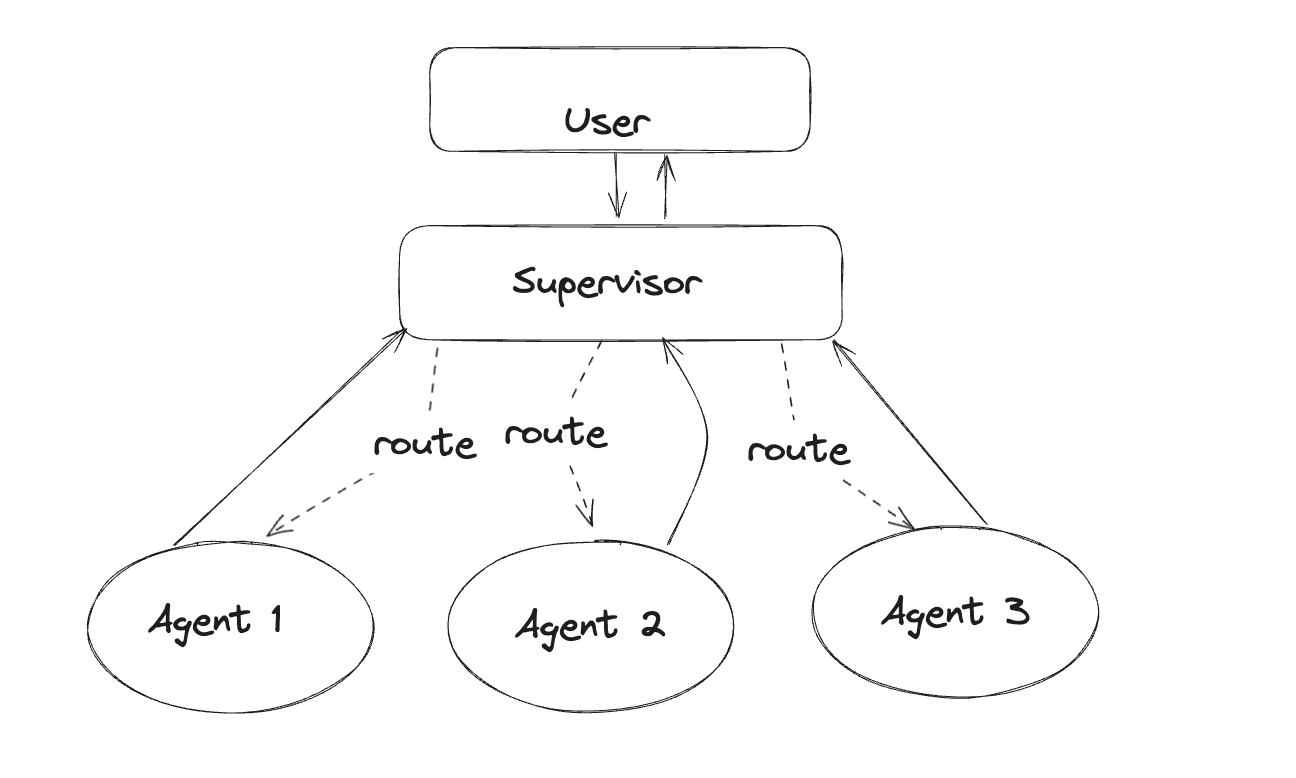

To simplify the code in each agent node, we will use LangGraph's prebuilt [create_react_agent](https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.chat_agent_executor.create_react_agent). This and other "advanced agent" notebooks are designed to show how you can implement certain design patterns in LangGraph. If the pattern suits your needs, we recommend combining it with some of the other fundamental patterns described elsewhere in the docs for best performance.

## Setup

First, let's install required packages and set our API keys

In [1]:
%%capture --no-stderr
%pip install -U langgraph langchain_community langchain_anthropic langchain_experimental

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-openai 0.1.23 requires langchain-core<0.3.0,>=0.2.35, but you have langchain-core 0.3.29 which is incompatible.
langchain-pinecone 0.0.3 requires langchain-core<0.2,>=0.1, but you have langchain-core 0.3.29 which is incompatible.


In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [3]:
_set_env("TAVILY_API_KEY")

TAVILY_API_KEY:  ········


<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>

## Create tools

For this example, you will make an agent to do web research with a search engine, and one agent to create plots. Define the tools they'll use below:

In [4]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)

# This executes code locally, which can be unsafe
repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return result_str

### Create Agent Supervisor

It will use LLM with structured output to choose the next worker node OR finish processing.

In [5]:
from typing import Literal
from typing_extensions import TypedDict

# from langchain_anthropic import ChatAnthropic
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState, END
from langgraph.types import Command


members = ["researcher", "coder"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]


# llm = ChatAnthropic(model="claude-3-5-sonnet-latest")
llm = ChatOpenAI(model="gpt-4o")


def supervisor_node(state: MessagesState) -> Command[Literal[*members, "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto)

## Construct Graph

We're ready to start building the graph. Below, define the state and worker nodes using the function we just defined.

In [6]:
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent


research_agent = create_react_agent(
    llm, tools=[tavily_tool], state_modifier="You are a researcher. DO NOT do any math."
)


def research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = research_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )


# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
code_agent = create_react_agent(llm, tools=[python_repl_tool])


def code_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = code_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )


builder = StateGraph(MessagesState)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("researcher", research_node)
builder.add_node("coder", code_node)
graph = builder.compile()

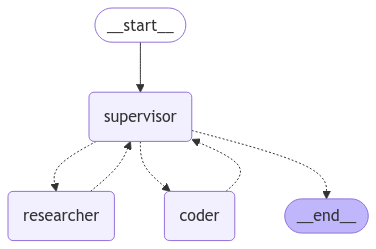

In [7]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

## Invoke the team

With the graph created, we can now invoke it and see how it performs!

In [8]:
for s in graph.stream(
    {"messages": [("user", "What's the square root of 42?")]}, subgraphs=True
):
    print(s)
    print("----")

((), {'supervisor': None})
----


Python REPL can execute arbitrary code. Use with caution.


(('coder:fbf26e16-9721-d5b5-1d94-b542a07d7062',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_C39d6TxvprWRqiMhY4YislCZ', 'function': {'arguments': '{"code":"import math\\nmath.sqrt(42)"}', 'name': 'python_repl_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 96, 'total_tokens': 120, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_b7d65f1a5b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f36e6eed-ca78-4720-97c4-100d6f904757-0', tool_calls=[{'name': 'python_repl_tool', 'args': {'code': 'import math\nmath.sqrt(42)'}, 'id': 'call_C39d6TxvprWRqiMhY4YislCZ', 'type': 'tool_call'}], usage_metadata={'input_tokens': 96, 'output_tokens': 24, 'tot

In [9]:
for s in graph.stream(
    {
        "messages": [
            (
                "user",
                "Find the latest GDP of New York and California, then calculate the average",
            )
        ]
    },
    subgraphs=True,
):
    print(s)
    print("----")

((), {'supervisor': None})
----
(('researcher:9ffd7fa3-643f-b4ce-752a-e1c6cc2a5b07',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ZmMBZhNEmUD89kW9AKC19OH9', 'function': {'arguments': '{"query": "latest GDP of New York 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_FPvWCZd5U7REl5xygm8WRN62', 'function': {'arguments': '{"query": "latest GDP of California 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 66, 'prompt_tokens': 104, 'total_tokens': 170, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_b7d65f1a5b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-6235d566-0f2b-4269-a7a6-9701f21